In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numba as nb

from distance import DIST_NAME_TO_ID
import nurs
import random

@nb.njit(cache=True)
def _seed_numba(seed: int) -> None:
    np.random.seed(seed)

def seed_everything(seed: int) -> None:
    import random
    np.random.seed(seed)
    random.seed(seed)
    _seed_numba(seed)


def _apply_style():
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "figure.figsize": (7.5, 4.75),
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.frameon": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
    })


def step_nurs(state, beta, dist_id, n, eps, max_doublings, w=None, l=None):
    if w is not None:
        rho = nurs.sample_qw(n, w)
    elif l is not None:
        rho = nurs.sample_ql(n, l)
    else:
        rho = nurs.sample_unif(n)
    return nurs.nurs_kernel(
        n=n,
        start_perm=np.asarray(state, dtype=np.int64),
        beta=beta,
        eps=eps,
        max_doublings=max_doublings,
        rho=rho.astype(np.int64, copy=False),
        dist_id=dist_id,
    )

def fixed_points(s):
    s = np.asarray(s, dtype=np.int64)
    return int(np.sum(s == np.arange(s.size, dtype=np.int64)))

def run_chain(n, dist_id, beta, burn_in, num_samples, eps, max_doublings, w=None, l=None, seed=None):
    if seed is not None:
        seed_everything(seed) 
    state = np.random.permutation(n)
    counts = np.empty(num_samples, dtype=int)
    total = burn_in + num_samples
    j = 0
    for t in range(total):
        state = step_nurs(state, beta, dist_id, n, eps, max_doublings, w=w, l=l )
        if t >= burn_in:
            counts[j] = fixed_points(state)
            last_state = state
            j += 1
    return counts, last_state


def poisson_overlay(ax, data, lam=None, label_data="Fixed points", label_pois=None):
    if lam is None:
        lam = float(np.mean(data))
    pois = np.random.poisson(lam, size=len(data))
    bins = np.arange(0, max(int(np.max(data)), int(np.max(pois))) + 2) - 0.5
    ax.hist(data, bins=bins, density=True, alpha=0.6, label=label_data)
    ax.hist(pois, bins=bins, density=True, alpha=0.4, label=label_pois or f"Poisson({lam:.3g})")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Number of fixed points")
    ax.set_ylabel("Density")
    ax.legend()

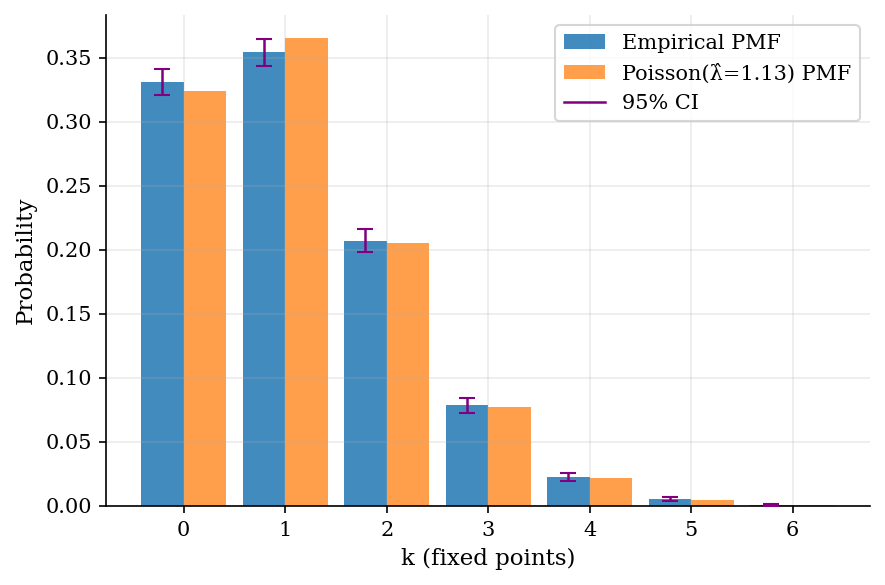

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math

def _pmf_and_ci(counts, z=1.959963984540054):
    kmax = int(np.max(counts))
    n_obs = len(counts)
    freq = np.bincount(counts, minlength=kmax + 1)[: kmax + 1]
    p = freq / n_obs
    denom = 1 + z**2 / n_obs
    center = (p + z**2 / (2 * n_obs)) / denom
    half = z * np.sqrt((p * (1 - p) / n_obs) + (z**2 / (4 * n_obs**2))) / denom
    lo = np.maximum(0.0, center - half)
    hi = np.minimum(1.0, center + half)
    yerr = np.vstack([p - lo, hi - p]).astype(float)
    yerr = np.nan_to_num(yerr, nan=0.0, posinf=0.0, neginf=0.0)
    yerr = np.clip(yerr, 0.0, None)
    return p, yerr

def _poisson_pmf(lam, kmax):
    k = np.arange(kmax + 1, dtype=float)
    log_p = -lam + k * np.log(lam) - np.vectorize(math.lgamma)(k + 1.0)
    p = np.exp(log_p)
    p /= p.sum()
    return p

if __name__ == "__main__":
    n = 1000
    burn_in = 2000
    num_samples = 8000
    eps = 1e-3
    seed = 0
    beta = 1.0 / n**2
    _apply_style()
    np.random.seed(seed)
    dist_id = DIST_NAME_TO_ID["L2"]
    max_doublings = 8
    w = 15
    l = None
    counts, _ = run_chain(
        n, dist_id, beta, burn_in, num_samples, eps, max_doublings,
        w=w, l=l, seed=seed
    )
    lam = float(np.mean(counts))
    p_emp, yerr = _pmf_and_ci(counts)
    kmax = int(np.max(counts))
    x = np.arange(kmax + 1)
    p_poi = _poisson_pmf(lam, kmax)
    fig, ax = plt.subplots(figsize=(6, 4))
    width = 0.42
    ax.bar(x - width/2, p_emp, width=width, alpha=0.85, label="Empirical PMF")
    ax.errorbar(x - width/2, p_emp, yerr=yerr, fmt="none", capsize=4, linewidth=1.2, zorder=3, color="purple")
    ax.bar(x + width/2, p_poi, width=width, alpha=0.75, label=f"Poisson(λ̂={lam:.2f}) PMF")
    ci_proxy = Line2D([0], [0], color="purple", lw=1.2, label="95% CI")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(ci_proxy); labels.append("95% CI")
    ax.set_xlabel("k (fixed points)")
    ax.set_ylabel("Probability")
    ax.set_xticks(x)
    ax.legend(handles, labels, frameon=True)
    fig.tight_layout()
    plt.show()